In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

## Question Formulation

### 1. The question

"Phương pháp xử lý missing values nào (Simple Univariate Imputation vs. Multivariate Iterative Imputation) là tối ưu nhất để bảo toàn cấu trúc phân phối thống kê của các đặc trưng có tỷ lệ missing values cao trong dữ liệu (`Sunshine`, `Evaporation`, `Cloud9am`, `Cloud3pm`)?"

### 2. Motivation & Benefits

#### 2.1. Why is this question worth investigating?
* Trong tập dữ liệu này, các biến số quan trọng như `Evaporation` (Lượng bốc hơi), `Sunshine` (Số giờ nắng) và `Cloud9am`, `Cloud3pm` (Lượng mây che phủ) có tỷ lệ thiếu hụt vô cùng báo động (lên tới 40-50%).
* Nếu xử lý bằng việc loại bỏ các dòng thiếu hụt này có thể làm giảm kích thước tập dữ liệu xuống một nửa, gây ra thiên kiến lựa chọn nghiêm trọng bởi một lượng lớn thông tin quan trọng bị mất đi. Còn nếu như xử lý bằng các phương pháp đơn giản, truyền thống như điền các giá trị Mean hay Median thì không phù hợp vì nó phớt lờ mối tương quan đa biến (Multivariate correlation) đặc trưng của khí tượng. Nó có thể vô tình gán giá trị mang tính trung bình cho cả những ngày mưa bão, tạo ra các điểm dữ liệu vô lý (ví dụ như mưa to nhưng nắng nhiều), đồng thời làm giảm phương sai, khiến mô hình mất khả năng nhận diện các hình thái thời tiết cực đoan.
* Do đó, việc tìm kiếm một phương pháp điền missing values bảo toàn được phân phối gốc là vô cùng quan trọng.

#### 2.2. What benefits or insights would be answering this question provide? 
* Bảo toàn mối quan hệ vật lý: Câu trả lời sẽ cho thấy liệu thuật toán đa biến (như Iterative Imputer/MICE) có khả năng tái tạo lại mối quan hệ nhân quả tự nhiên hay không (ví dụ như nhiệt độ cao kết hợp với độ ẩm thấp có thể dẫn đến lượng bốc hơi nhiều). Điều này đảm bảo dữ liệu sau khi xử lý vẫn tuân theo các quy luật tự nhiên vốn có.
* Cải thiện hiệu suất mô hình dự báo: `Evaporation` và `Sunshine` được xem là những dấu hiệu quan trọng nhất của mưa. Bởi thế mà dữ liệu đầu vào chất lượng cao hơn (ít nhiễu, giữ được độ lệch chuẩn) sẽ trực tiếp dẫn đến độ chính xác cao hơn cho mô hình học máy dự báo giá trị `RainTomorrow` về sau.

#### 2.3. Who would care about the answer?

* Các nhà khoa học dữ liệu: Quan tâm đến phương pháp chung để xử lý missing values trong các tập dữ liệu có tính tương quan cao.
* Các chuyên gia khí tượng thủy văn: Cần các bộ dữ liệu đầy đủ và liên tục để chạy các mô hình mô phỏng khí hậu dài hạn.
* Lĩnh vực năng lượng tái tạo (Điện mặt trời): Cần dữ liệu `Sunshine` chính xác và đầy đủ để dự tính sản lượng điện năng, ngay cả khi trạm đo bị hỏng hóc thiết bị trong một số ngày.

#### 2.4. What real-world problem or decision does this inform? 

* Dự báo hạn hán và quản lý nguồn nước: Dữ liệu của `Evaporation` là tham số cốt lõi để tính toán cân bằng nước trong nông nghiệp. Việc khôi phục chính xác dữ liệu bốc hơi bị thiếu giúp nông dân và nhà quản lý đưa ra quyết định tưới tiêu chính xác hơn, tránh lãng phí nước hoặc để cây trồng bị khô hạn.
* Tính ổn định của hệ thống cảnh báo sớm: Đảm bảo hệ thống dự báo thời tiết vẫn hoạt động ổn định và đưa ra cảnh báo chính xác ngay cả khi các cảm biến thu thập dữ liệu tại trạm quan trắc gặp sự cố gián đoạn.

## Data analysis

### 1. Preprocessing

#### 1.1. Written explanation

* Để giải quyết vấn đề missing values nghiêm trọng ở các biến dữ liệu `Evaporation`, `Sunshine` và `Cloud9am`, `Cloud3pm`, nhóm thiết lập quy trình tiền xử lý gồm 3 bước chính. Mục tiêu là tạo ra hai phiên bản dữ liệu sạch để so sánh hiệu quả.

* Workflow như sau:
  * Lựa chọn đặc trưng: Chọn các biến mục tiêu (Missing) và các biến ngữ cảnh (Correlated)
  * Cấu hình imputer: Tách thành 2 luồng xử lý
      * Simple Imputation: Dùng Trung vị - Median để điền vào, hướng đến việc xử lý đơn giản, nhanh gọn nhưng độ hiệu quả không cao.
      * Iterative Imputation: Dùng thuật toán MICE, hướng đến việc dùng mô hình hồi quy đa biến để dự đoán giá trị thiếu dựa trên các thông số về nhiệt độ, độ ẩm.
  * Cuối cùng là kiểm tra lại dữ liệu sau khi điền.

* Logic và lí do cho từng bước xử lý:
  * Lựa chọn đặc trưng: Ngoài việc chọn các cột bị thiếu như `Evaporation`, `Sunshine` và `Cloud9am`, `Cloud3pm`, nhóm còn đưa vào các cột đóng vai trò hỗ trợ cho điền missing values là `MinTemp`, `MaxTemp`, `Humidity9am`, `Humidity3pm`, `Rainfall`. Lý do: Thuật toán MICE cần thông tin ngữ cảnh, ví dụ như có thể học được quy luật "Nhiệt độ cao + Độ ẩm thấp = Bốc hơi mạnh", từ đó mà điền giá trị cho `Evaporation` chính xác hơn.
  * Cấu hình Imputer:
      * SimpleImputer: Lựa chọn Median để điền missing values vì tính chất của các cột bị thiếu này có phân phối lệch, vậy nên Median sẽ ít bị ảnh hưởng bởi các giá trị ngoại lai hơn thay vì điền Mean.
      * IterativeImputer: Dùng thuật toán MICE và thiết lập min_value=0. Lý do là để đảm bảo các biến dữ liệu thiếu không bao giờ bị dự đoán ra số âm.
  * Kiểm tra lại dữ liệu sau khi điền: Tập trung đảm bảo không còn giá trị Null và không có giá trị âm (các giá trị vô lý). 

#### 1.2. Code implementation

* Lựa chọn đặc trưng

In [2]:
weather_path = "../data/raw/weatherAUS.csv"
df_weather = pd.read_csv(weather_path)

cols_missing = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']

cols_context = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Rainfall']

cols_selected = cols_missing + cols_context
df_weather_subset = df_weather[cols_selected].copy()

* Cấu hình imputer

In [3]:
# Simple Imputer 
simple_imputer = SimpleImputer(strategy='median')

df_weather_simple = pd.DataFrame(simple_imputer.fit_transform(df_weather_subset), columns=cols_selected)

# Iterative Imputer
mice_imputer = IterativeImputer(max_iter=50, random_state=42, min_value=0)

df_weather_mice = pd.DataFrame(mice_imputer.fit_transform(df_weather_subset), columns=cols_selected)

* Kiểm tra lại sau khi điền missing value

In [4]:
print(f"The number of remaining null values: {df_weather_mice[cols_missing].isnull().sum().sum()}")
print(f"The min value of Sunshine: {df_weather_mice['Sunshine'].min()}")

The number of remaining null values: 0
The min value of Sunshine: 0.0


Kết quả cho thấy công việc xử lý missing values thành công khi không còn giá trị Null nào, ngoài ra cũng đảm bảo dữ liệu không xuất hiện các giá trị vô lý.

### 2. Analysis

#### 2.1. Written explanation

Để đánh giá hiệu quả của hai phương pháp điền khuyết dữ liệu (Simple Imputation và Iterative Imputation) đối với các biến khí tượng thiếu hụt nhiều (`Evaporation`, `Sunshine` và `Cloud9am`, `Cloud3pm`), nhóm sử dụng phương pháp phân tích so sánh định lượng dựa trên 3 tiêu chí cốt lõi:
* Bảo toàn Phân phối (Distribution Preservation):
    * Phương pháp: Sử dụng biểu đồ mật độ xác suất (Kernel Density Estimation - KDE).
    * Lý do: Giúp phát hiện các biến dạng của dữ liệu sau khi điền. Đó là bởi phương pháp điền khuyết tốt phải tái tạo được hình dáng đường cong phân phối gốc, tránh tạo ra các đỉnh nhọn nhân tạo (spikes) làm sai lệch thống kê mô tả.
* Bảo toàn Biến thiên (Variance Retention):
    * Phương pháp: Tính toán và so sánh Độ lệch chuẩn (Standard Deviation) trước và sau khi xử lý.
    * Lý do: Trong khí tượng, sự biến thiên (variance) đại diện cho thông tin về các hiện tượng thời tiết cực đoan. Nhóm sẽ hướng đến việc tính Phần trăm mất mát phương sai (% Variance Loss) để xem phương pháp nào làm phẳng dữ liệu ít hơn.
* Kiểm tra Tính nhất quán trong Vật lý (Physical Consistency):
    * Phương pháp: Đo lường Hệ số tương quan Pearson giữa `Evaporation` (Lượng bốc hơi) và `MaxTemp` (Nhiệt độ cao nhất).
    * Lý do: Theo quy luật vật lý, nhiệt độ cao thường thúc đẩy bốc hơi. Vì vậy, phương pháp điền khuyết tối ưu phải giữ được mối tương quan dương này, thay vì tạo ra các dữ liệu nhiễu vô lý.

#### 2.2. Code implementation

* Bảo toàn Phân phối

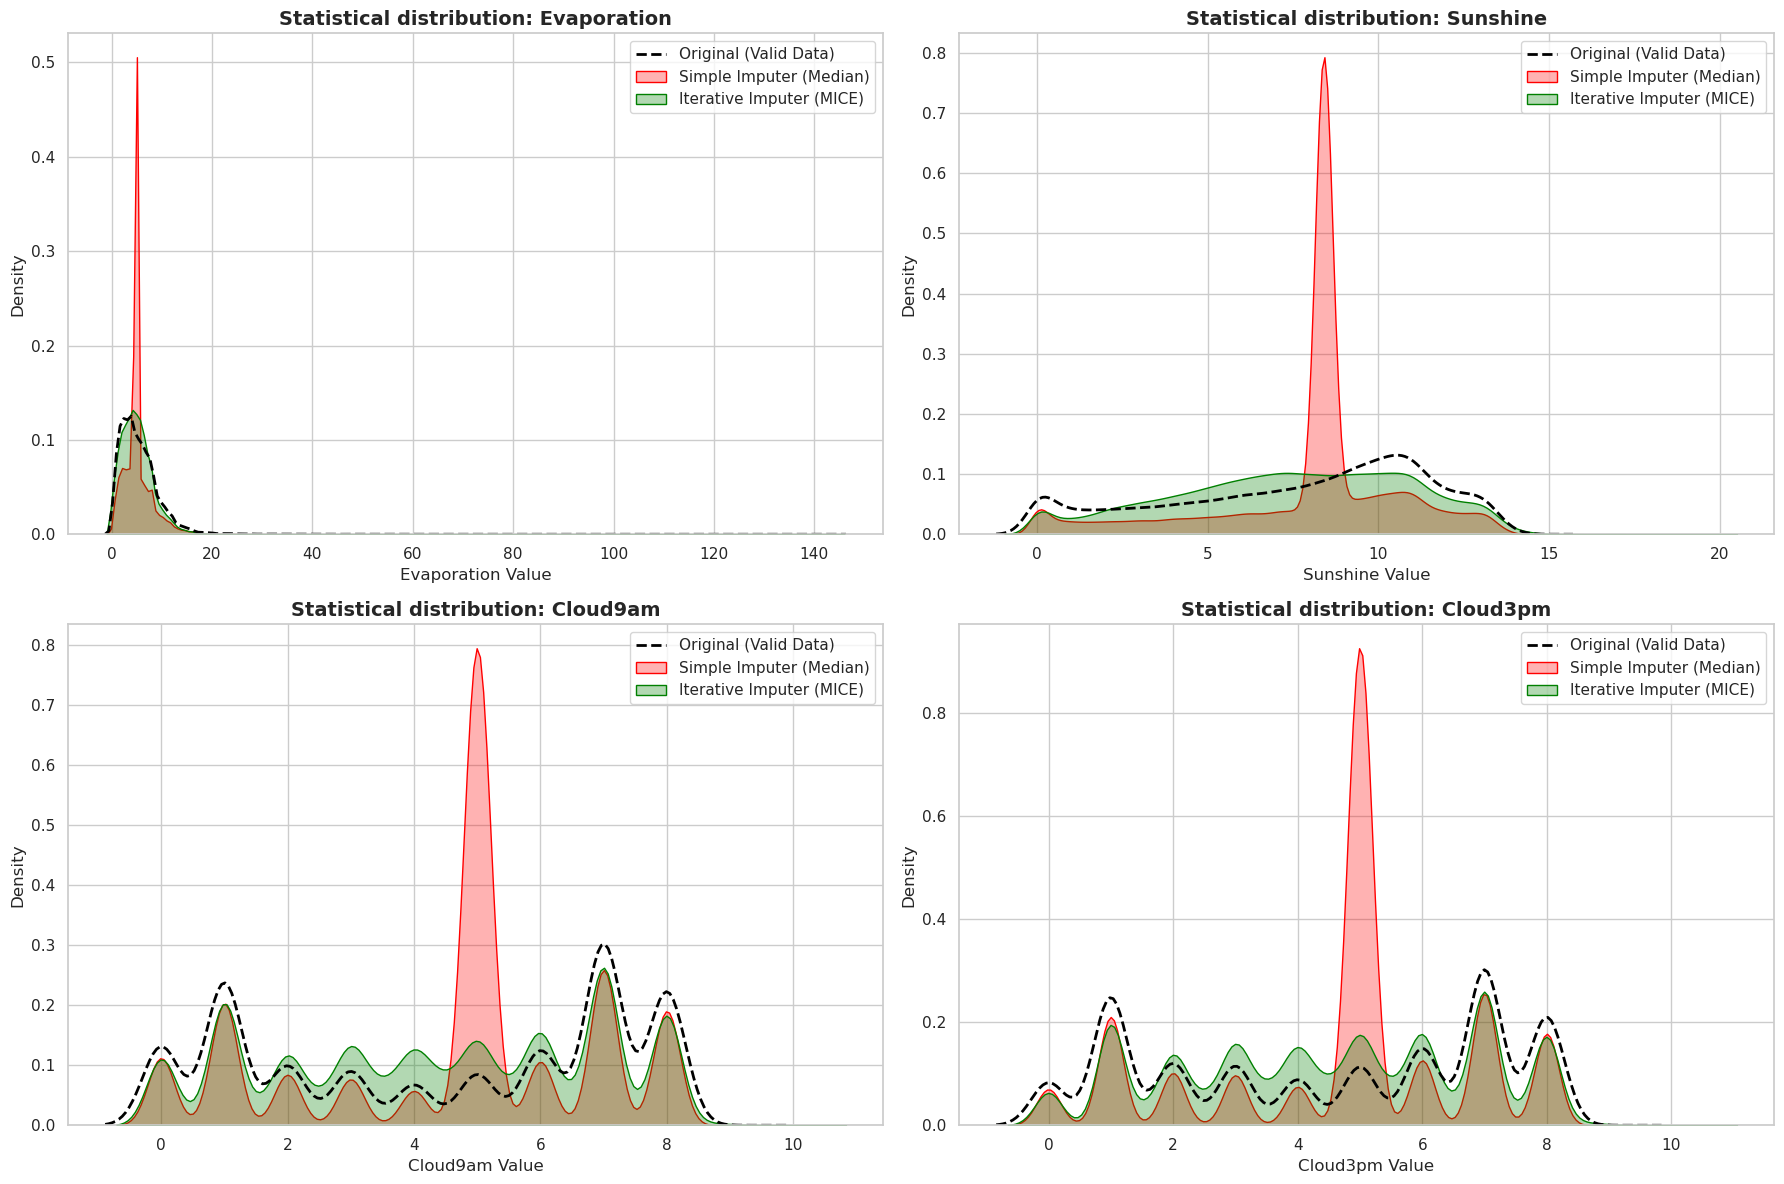

In [5]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes = axes.flatten()

for i, feature in enumerate(cols_missing):
    ax = axes[i]
    
    # Plot Original Data 
    sns.kdeplot(df_weather_subset[feature].dropna(), ax=ax, 
                color='black', linestyle='--', linewidth=2, label='Original (Valid Data)')
    
    # Plot Simple Imputation (Median)
    sns.kdeplot(df_weather_simple[feature], ax=ax, 
                color='red', fill=True, alpha=0.3, label='Simple Imputer (Median)')
    
    # Plot Iterative Imputation (MICE)
    sns.kdeplot(df_weather_mice[feature], ax=ax, 
                color='green', fill=True, alpha=0.3, label='Iterative Imputer (MICE)')
    
    ax.set_title(f'Statistical distribution: {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{feature} Value')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Quan sát từ biểu đồ KDE (mật độ xác suất) này, phương pháp Simple Imputation (đường màu đỏ) tạo ra một đỉnh nhọn bất thường ngay tại giá trị trung vị (ví dụ như khoảng 4.8mm cho `Evaporation` hay 8h cho `Sunshine`). Đây là hệ quả tất yếu của việc gán cùng một con số cho hàng chục nghìn điểm dữ liệu thiếu và sự xuất hiện của đỉnh nhọn này gây ra sai lệch (bias) trong thống kê bởi nó làm cho dữ liệu tập trung quá mức vào giá trị trung tâm. Ngược lại thì MICE Imputation (đường màu xanh) tạo ra một đường cong mềm mại, bao phủ gần như trùng khớp với đường phân phối của dữ liệu gốc (nét đứt màu đen).

* Bảo toàn Biến thiên

In [6]:
comparison_stats = []

for col in cols_missing:
    original_std = df_weather_subset[col].std()
    simple_std = df_weather_simple[col].std()
    mice_std = df_weather_mice[col].std()
    
    loss_simple = ((simple_std - original_std) / original_std) * 100
    loss_mice = ((mice_std - original_std) / original_std) * 100
    
    comparison_stats.append({
        'Variable': col,
        'Original Std': original_std,
        'Simple Std': simple_std,
        'MICE Std': mice_std,
        'Var Loss (Simple)': f"{loss_simple:.2f}%",
        'Var Loss (MICE)': f"{loss_mice:.2f}%"
    })

df_variance_stats = pd.DataFrame(comparison_stats)
display(df_variance_stats)

,Variable,Original Std,Simple Std,MICE Std,Var Loss (Simple),Var Loss (MICE)
0,Evaporation,4.193704,3.178819,3.634719,-24.20%,-13.33%
1,Sunshine,3.785483,2.757790,3.432737,-27.15%,-9.32%
2,Cloud9am,2.887159,2.281490,2.533482,-20.98%,-12.25%
3,Cloud3pm,2.720357,2.106768,2.341353,-22.56%,-13.93%


Kết quả tính toán cho thấy Simple Imputation làm sụt giảm độ lệch chuẩn từ 21% đến 27% tùy biến, làm mất mát 1 lượng thông tin khổng lồ bởi nó đồng nghĩa với dấu hiệu cào bằng dữ liệu, cụ thể là những ngày nắng nóng kỷ lục hay âm u cực độ (vốn bị thiếu số liệu do cảm biến hỏng trong điều kiện khắc nghiệt) nay bị biến thành những ngày bình thường. Trong khi đó MICE Imputation kiểm soát mức sụt giảm này tốt hơn nhiều, chỉ mất khoảng 9% đến 14% nhờ cơ chế hồi quy có cộng thêm sai số ngẫu nhiên nên đã khôi phục được sự biến thiên, giúp giữ lại các tín hiệu cực đoan cần thiết để phát hiện dị thường (anomaly detection).

* Bảo toàn Tương quan về tính Vật lý

In [7]:
target_pair = ['Evaporation', 'MaxTemp']

corr_stats = {
    'Original': df_weather_subset[target_pair].corr().iloc[0, 1],
    'Simple': df_weather_simple[target_pair].corr().iloc[0, 1],
    'MICE': df_weather_mice[target_pair].corr().iloc[0, 1]
}
print(f"Correlation Coefficient between Evaporation và MaxTemp\n{corr_stats}")

Correlation Coefficient between Evaporation và MaxTemp
{'Original': 0.5879322271019112, 'Simple': 0.44728854392876044, 'MICE': 0.6742747719039104}


### 3. Results & Interpretation 

#### 3.1. Answer the question with evidence 

Dựa trên các bằng chứng thực nghiệm từ quá trình phân tích ở trên, Multivariate Iterative Imputation (thuật toán MICE) là phương pháp tối ưu nhất để xử lý dữ liệu thiếu trong tập dữ liệu này, vượt trội hoàn toàn so với phương pháp Simple Imputation truyền thống. Bằng chứng cụ thể nằm ở 3 yếu tố:

* Bảo toàn Phân phối: Biểu đồ từ KDE ở phần Analysis đã cho thấy Iterative Imputation đã thể hiện gần như tương đồng với hình dáng đường cong phân phối gốc.

* Bảo toàn Biến thiên: Như thể hiện ở biểu đồ kết quả bên dưới, phương pháp Simple Imputation làm sụt giảm nghiêm trọng độ lệch chuẩn của biến `Sunshine` (-27.1%), `Evaporation` (-24.2%), `Cloud9am` (-21.0%), `Cloud3pm` (-22.6%). Ngược lại, MICE hạn chế mức sụt giảm này xuống còn khoảng -9.3% đến -13.9% ở 4 biến dữ liệu, bảo toàn được phần lớn thông tin về sự dao động của thời tiết.

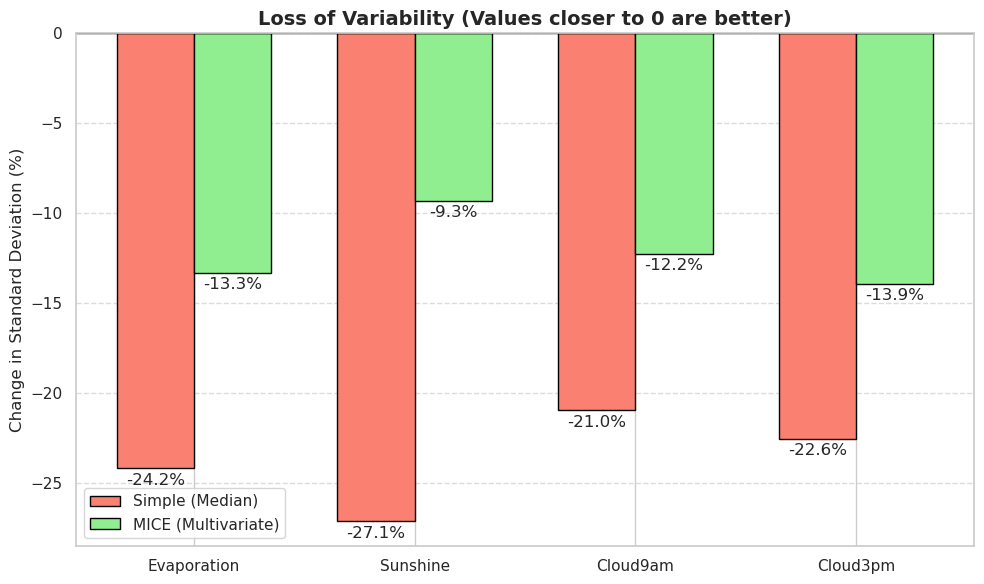

In [8]:
loss_simple = df_variance_stats['Var Loss (Simple)'].to_numpy()
loss_simple = np.char.rstrip(loss_simple.astype(str), '%').astype(float)
loss_mice = df_variance_stats['Var Loss (MICE)'].to_numpy()
loss_mice = np.char.rstrip(loss_mice.astype(str), '%').astype(float)

plt.figure(figsize=(10, 6))

x = np.arange(len(cols_missing))
width = 0.35

rects1 = plt.bar(x - width/2, loss_simple, width, label='Simple (Median)', color='salmon', edgecolor='black')
rects2 = plt.bar(x + width/2, loss_mice, width, label='MICE (Multivariate)', color='lightgreen', edgecolor='black')

plt.ylabel('Change in Standard Deviation (%)')
plt.title('Loss of Variability (Values closer to 0 are better)', fontweight='bold', fontsize=14)
plt.xticks(x, cols_missing)
plt.axhline(0, color='black', linewidth=1) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.bar_label(rects1, fmt='%.1f%%', padding=3)
plt.bar_label(rects2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

* Bảo toàn Tương quan về tính Vật lý: Biểu đồ thể hiện kết quả thu được ở phần phân tích đã thể hiện rằng phương pháp Simple Imputation làm gãy đổ mối tương quan giữa `MaxTemp` (Nhiệt độ) và `Evaporation` (Lượng bốc hơi) (hệ số giảm từ 0.59 xuống 0.45), tạo ra những dữ liệu vô lý (ví dụ như nhiệt độ thay đổi nhưng bốc hơi không đổi). Trong khi đó, MICE không chỉ khôi phục mà còn củng cố mối quan hệ này lên mức 0.67, phản ánh đúng tính chất vật lý trong dữ liệu.

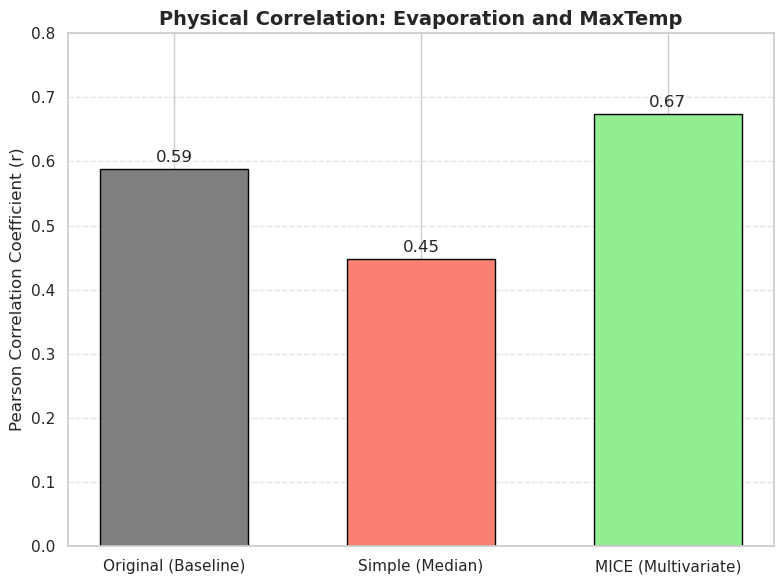

In [9]:
corrs = [
    df_weather_subset[['Evaporation', 'MaxTemp']].corr().iloc[0,1],
    df_weather_simple[['Evaporation', 'MaxTemp']].corr().iloc[0,1],
    df_weather_mice[['Evaporation', 'MaxTemp']].corr().iloc[0,1]
]
labels = ['Original (Baseline)', 'Simple (Median)', 'MICE (Multivariate)']
colors = ['gray', 'salmon', 'lightgreen']

plt.figure(figsize=(8, 6))

bars = plt.bar(labels, corrs, color=colors, edgecolor='black', width=0.6)

plt.title('Physical Correlation: Evaporation and MaxTemp', fontweight='bold', fontsize=14)
plt.ylabel('Pearson Correlation Coefficient (r)')
plt.ylim(0, 0.8) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.bar_label(bars, fmt='%.2f', fontsize=12, padding=3)

plt.tight_layout()
plt.show()

#### 3.2. Practical Meaning & Implications

Việc áp dụng MICE có ý nghĩa quan trọng đối với sự chính xác khi xây dựng mô hình dự báo mưa:
* Ổn định cho phân phối
* Dự báo cực đoan tốt hơn: Nhờ giữ lại được độ phương sai (Variance), dữ liệu sau khi xử lý bằng MICE vẫn chứa đựng các tín hiệu về những ngày nắng gắt hoặc âm u bất thường. Đây là chìa khóa để mô hình học được cách dự báo các hiện tượng thời tiết khắc nghiệt (bão, hạn hán) thay vì chỉ dự báo những ngày bình thường.
* Loại bỏ nhiễu: Việc hệ số tương quan của MICE (0.67) cao hơn cả dữ liệu gốc (0.59) cho thấy thuật toán đã có tác dụng khử nhiễu (denoising), tạo ra một bộ dữ liệu sạch hơn và logic hơn để đưa vào huấn luyện.

#### 3.3. Surprises & Limitations

- Một phát hiện thú vị là MICE có khả năng sửa lỗi cho dữ liệu gốc thông qua việc tăng cường mối tương quan vật lý. Nó tận dụng thông tin từ Nhiệt độ và Độ ẩm để điền vào missing values tốt hơn cả mong đợi.
- Mặc dù vậy, MICE vẫn không thể khôi phục 100% độ biến thiên của dữ liệu thực tế (vẫn mất khoảng 10%). Điều này có nghĩa là một số giá trị ngoại lai cực hiếm (extreme outliers) có thể đã bị kéo nhẹ về phía trung bình trong quá trình hồi quy.